In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split

Загружаем данные.

In [45]:
df = pd.read_csv("housing.csv", header=None, delimiter='\s+')
X = df.drop([13], axis=1)
y = df[13]
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


Разделим данные на трейн и тест.

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Построим кривые обучения для метода RandomForest и KNeighbors. В качестве метрики выберем логарифм MSE, так как значения ошибок на тесте в начале обучения будут очень большими и логарифмическая шкала позволит графику быть понятным.

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_log_error

In [48]:
def plot_learning_curve(model, model_name, target_metric=False):
    train_size, train_scores, test_scores = learning_curve(
        model, X, y, cv=50, scoring='neg_mean_squared_log_error'
    )
    plt.plot(train_size, -train_scores.mean(axis=1), label="Train")
    plt.plot(train_size, -test_scores.mean(axis=1), label="Test")
    plt.title(model_name)
    plt.xlabel("Training set size")
    plt.ylabel("MSE")

    if target_metric:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_log_error(y_test, y_pred)
        plt.plot(train_size, len(train_size) * [mse], label="Target metric", color='r', linestyle='--')
        
    plt.legend()
    plt.grid(True)
    plt.show()

Для RandomForest:

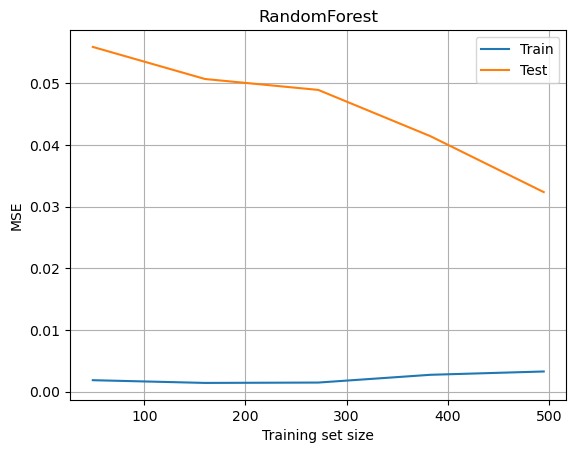

In [49]:
plot_learning_curve(RandomForestRegressor(random_state=0), "RandomForest")

Видно, что RandomForest немного переобучается на тренировочной выборке. Предположим, что целевое значение метрики где то на уровне 0.02. Отобразим его на графике обучения:

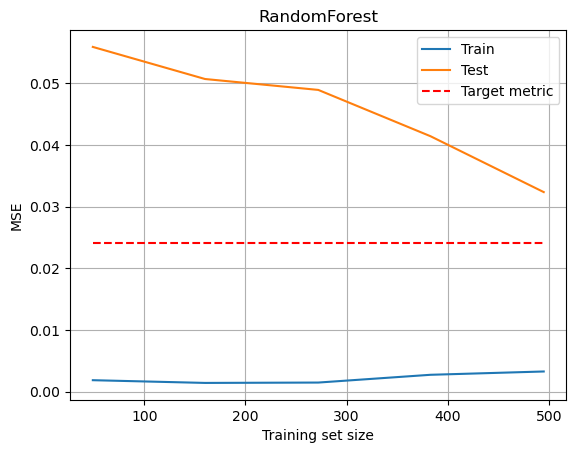

In [50]:
plot_learning_curve(RandomForestRegressor(random_state=0),"RandomForest", True)

Значение метрики оказалось примерно 0.024.

Теперь для метода ближайших соседей:

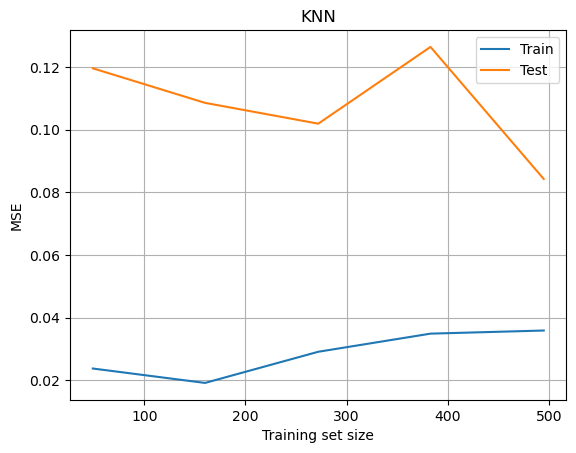

In [51]:
plot_learning_curve(KNeighborsRegressor(), "KNN")

Тут модель не успевает обучиться. Предположим, что целевое значение метрики будет меньше, на уровне 0.06. Построим его на графике:

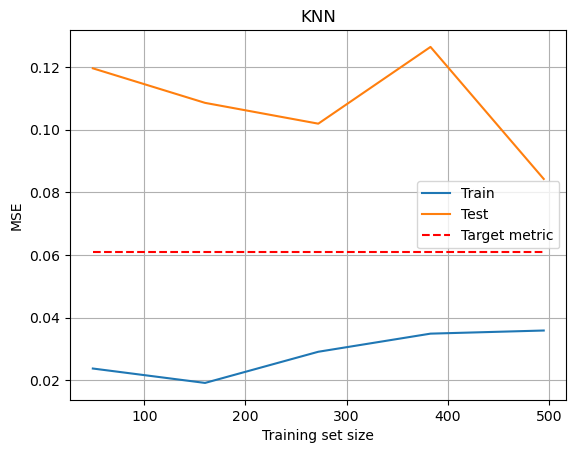

In [52]:
plot_learning_curve(KNeighborsRegressor(), "KNN", True)

Примерно так и есть.

Более подходящим для датасета оказалась RandomForest. Хоть она и переобучилась, но все равно дает лучшее качество по метрике.

Обучим обычную линейную регрессию, с Lasso регуляризацией и Ridge регуляризацией и оценим их качество с помощью MSE, MAE и R2:

In [53]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [54]:
def train_and_score(model, model_name):
    print(model_name)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("Метрики на трейне:")
    print("MSE:", mean_squared_error(y_train, y_pred_train))
    print("MAE:", mean_absolute_error(y_train, y_pred_train))
    print("R2:", r2_score(y_train, y_pred_train))
    print("Метрики на тесте:")
    print("MSE:", mean_squared_error(y_test, y_pred_test))
    print("MAE:", mean_absolute_error(y_test, y_pred_test))
    print("R2:", r2_score(y_test, y_pred_test))
    return model.coef_, model.intercept_

In [55]:
weights = []
intercepts = []
lr_weights, lr_intercept = train_and_score(LinearRegression(), "Линейная регрессия\n")
weights.append(lr_weights)
intercepts.append(lr_intercept)
lasso_weights, lasso_intercept = train_and_score(Lasso(), "\nLasso регуляризация\n")
weights.append(lasso_weights)
intercepts.append(lasso_intercept)
ridge_weights, ridge_intercept = train_and_score(Ridge(), "\nГребневая регуляризация\n")
weights.append(ridge_weights)
intercepts.append(ridge_intercept)

Линейная регрессия

Метрики на трейне:
MSE: 19.958219814238046
MAE: 3.1036061039080085
R2: 0.7645451026942549
Метрики на тесте:
MSE: 27.195965766883273
MAE: 3.609904060381817
R2: 0.6733825506400188

Lasso регуляризация

Метрики на трейне:
MSE: 24.71652261843586
MAE: 3.488373914641317
R2: 0.7084095500978869
Метрики на тесте:
MSE: 32.34503899856862
MAE: 3.8297992589493264
R2: 0.6115433359595555

Гребневая регуляризация

Метрики на трейне:
MSE: 20.144793664654504
MAE: 3.1051647762134658
R2: 0.7623440182689594
Метрики на тесте:
MSE: 27.76222459216652
MAE: 3.602077378024107
R2: 0.666581909148669


Лучше всех оказалась модель без регуляризации. Притом модель с L2 регуляризацией не сильно отличается от обычной качеством. Модель с L1 регуляризацией оказалась худшей.

Построим таблицу с весами моделей:

In [56]:
weights_df = pd.DataFrame(weights, index=["Логистическая регрессия", "Lasso", "Ridge"])
weights_df["Сдвиг"] = intercepts
weights_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,Сдвиг
Логистическая регрессия,-0.121310,0.044466,0.011342,2.511246,-16.231253,3.859068,-0.009985,-1.500270,0.242143,-0.011072,-1.017753,0.006814,-0.486738,37.937108
Lasso,-0.065862,0.048329,-0.000000,0.000000,-0.000000,0.868985,0.012180,-0.751094,0.200074,-0.013951,-0.846024,0.006688,-0.732666,44.965453
Ridge,-0.118309,0.046126,-0.020863,2.458686,-8.259585,3.897485,-0.017914,-1.397372,0.218432,-0.011634,-0.931711,0.007270,-0.494047,32.536986


По весам регрессии с Lasso, понимаем, что признаки 2-4 совсем незначими, признаки 0, 1, 6, 9, 11 не сильно значими. Наиболее значимыми являются признаки 5, 7, 10, 12.

Рассмотрим теперь коррелированность данных:

In [57]:
X.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
1,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
2,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
3,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
4,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
5,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
6,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
7,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
8,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
9,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


Видно, что много признаков коррелируют и вес одного из таких признаков, как правило, большой, а другой маленький.